In [1]:
'''Clear out temporary variables and get a clean session'''
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

In [2]:
'''Import necessary libraries'''
import pandas as pd
import numpy as np
import os
import glob
import re
import math

import missingno as msno
import pickle
import bz2

import sklearn
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import set_config
from pca import pca
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score

import seaborn as sns
from scipy.stats import skew, skewtest

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [3]:
'''Open pickled file'''
with open('mib_final.pkl', 'rb') as f:
    df = pickle.load(f)

<AxesSubplot:>

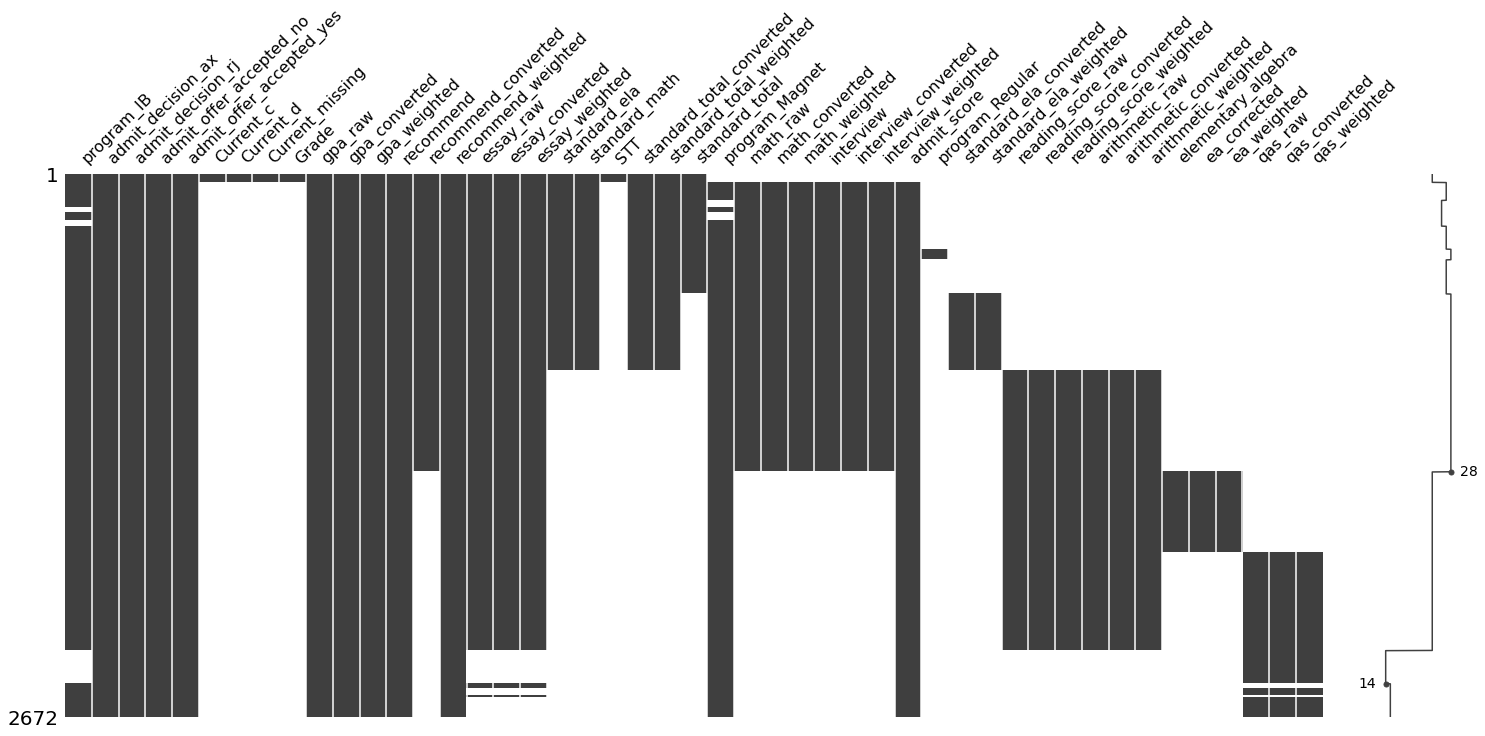

In [4]:
msno.matrix(df)

In [5]:
'''Combine data columns'''
df['math_raw'] = df['math_raw'].combine_first(df['arithmetic_raw'])
df['math_converted'] = df['math_converted'].combine_first(df['arithmetic_converted'])
df['math_weighted'] = df['math_weighted'].combine_first(df['arithmetic_weighted'])

df['standard_ela'] = df['standard_ela'].combine_first(df['reading_score_raw'])

<AxesSubplot:>

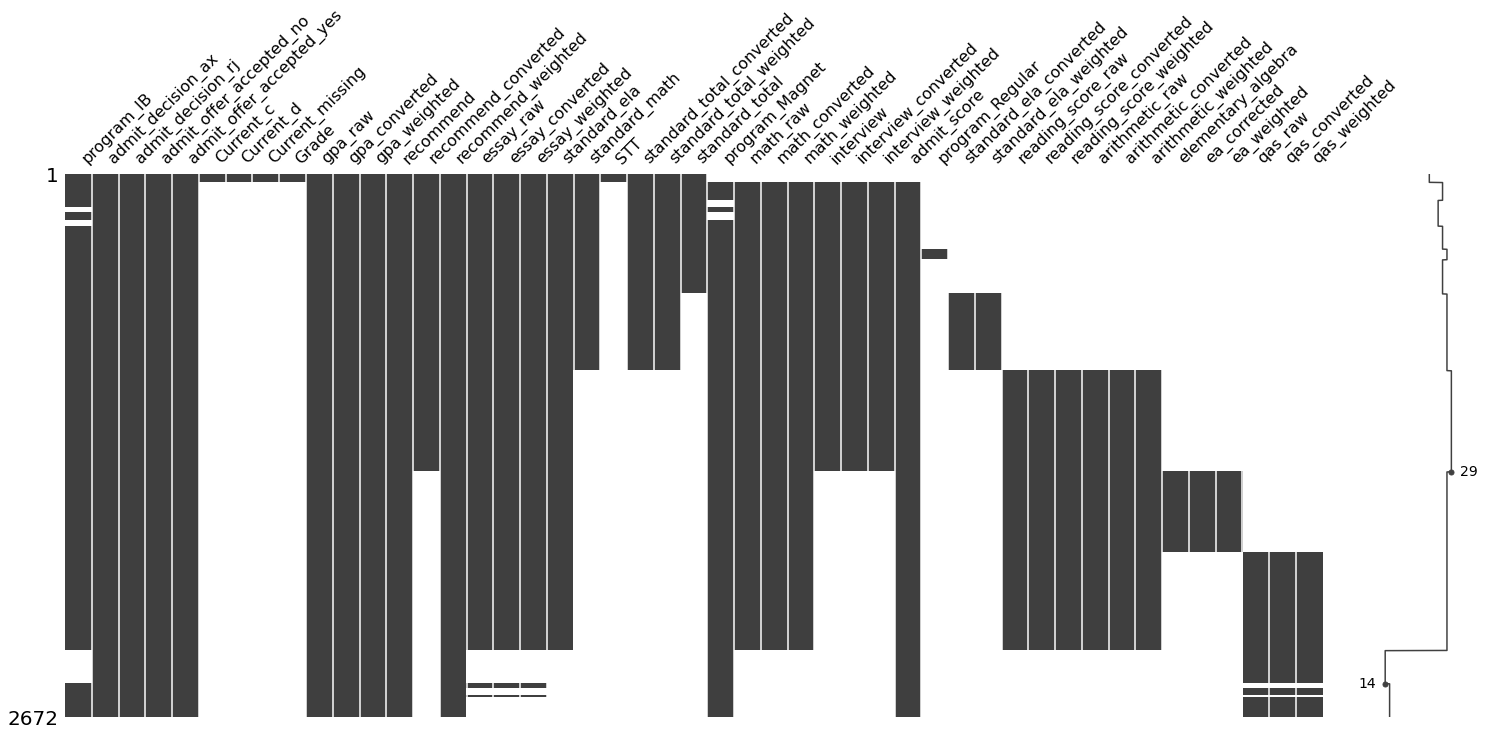

In [6]:
msno.matrix(df)

In [7]:
'''Further combine data columns'''
df['math_raw'] = df['math_raw'].combine_first(df['qas_raw'])
df['math_converted'] = df['math_converted'].combine_first(df['qas_converted'])
df['math_weighted'] = df['math_weighted'].combine_first(df['qas_weighted'])

<AxesSubplot:>

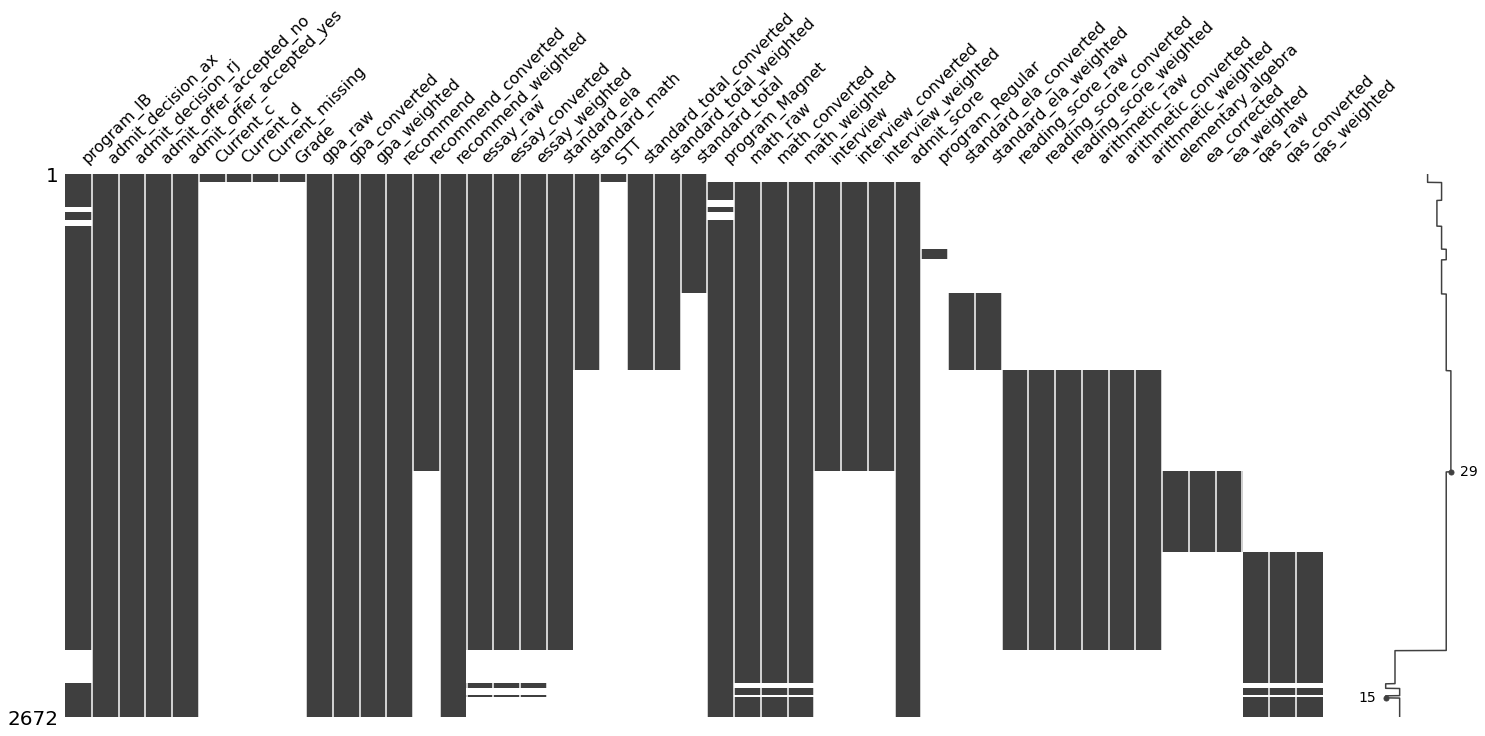

In [8]:
msno.matrix(df)

In [9]:
'''Drop duplicate and/or sparse columns'''
df.drop(['standard_math', 'standard_total', 'standard_total_converted', 'standard_total_weighted',\
         'standard_ela_converted', 'standard_ela_weighted', 'reading_score_raw','reading_score_converted',\
         'reading_score_weighted', 'arithmetic_raw', 'arithmetic_converted', 'arithmetic_weighted', 'qas_raw', 'qas_converted',\
         'qas_weighted', 'elementary_algebra', 'ea_corrected', 'ea_weighted'], axis = 1, inplace=True)

In [10]:
'''Fill NaNs in program columns'''

df['program_IB'].replace(np.nan, 0, inplace = True)
df['program_Magnet'].replace(np.nan, 0, inplace = True)

In [11]:
'''Create column for program/acceptance status'''
conditions = [
    (df['program_IB'] == 0) & (df['admit_decision_ax'] == 0),
    (df['program_IB'] == 0) & (df['admit_decision_ax'] == 1),
    (df['program_IB'] == 1) & (df['admit_decision_ax'] == 0),
    (df['program_IB'] == 1) & (df['admit_decision_ax'] == 1)]

values = ['Magnet-Rejected', 'Magnet-Accepted', 'IB-Rejected', 'IB-Accepted']

df['program_admit'] = np.select(conditions, values)

<AxesSubplot:>

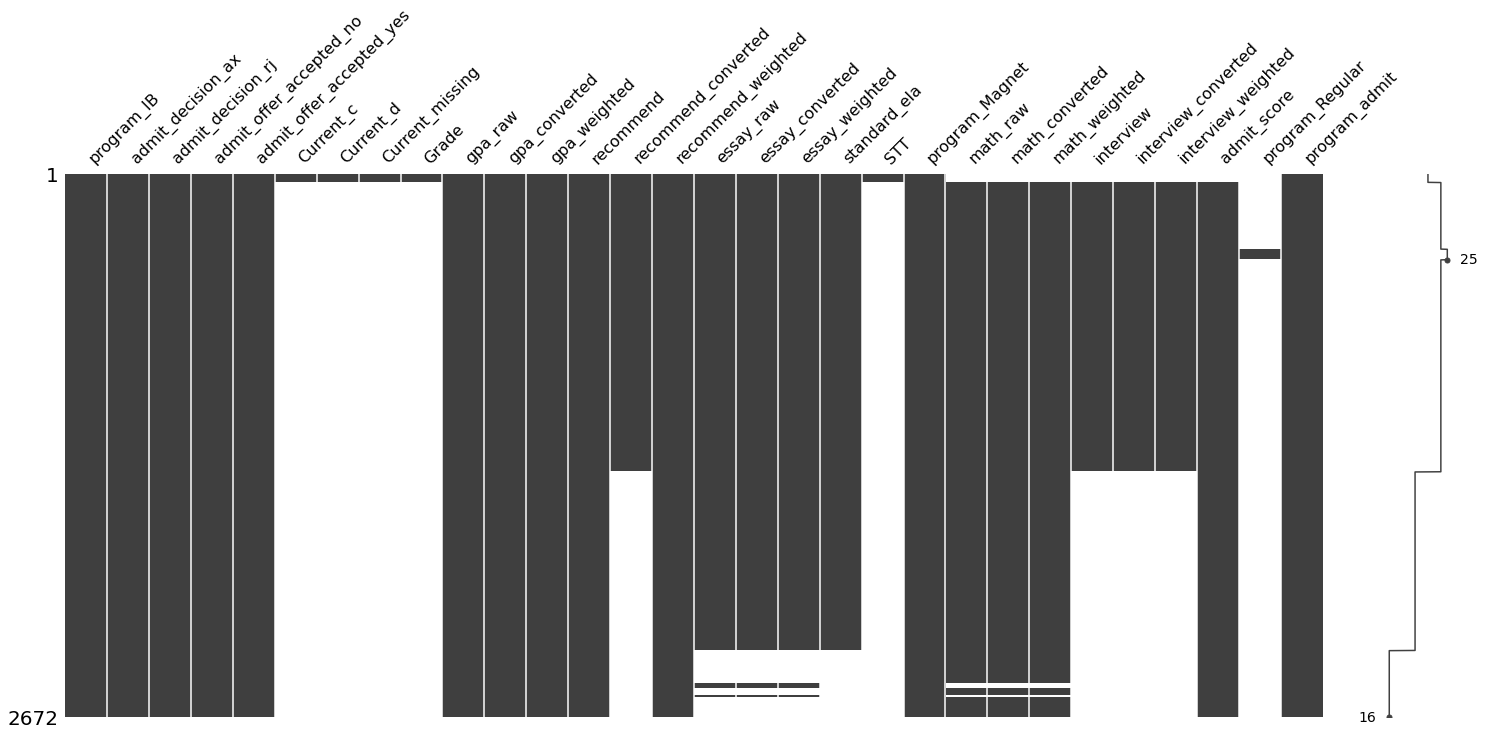

In [12]:
msno.matrix(df)

In [13]:
drop_columns = ['Current_c', 'Current_d', 'Current_missing', 'Grade', 'STT', 'program_Regular', 'program_Magnet']
df.drop(drop_columns, axis = 1, inplace = True)

<AxesSubplot:>

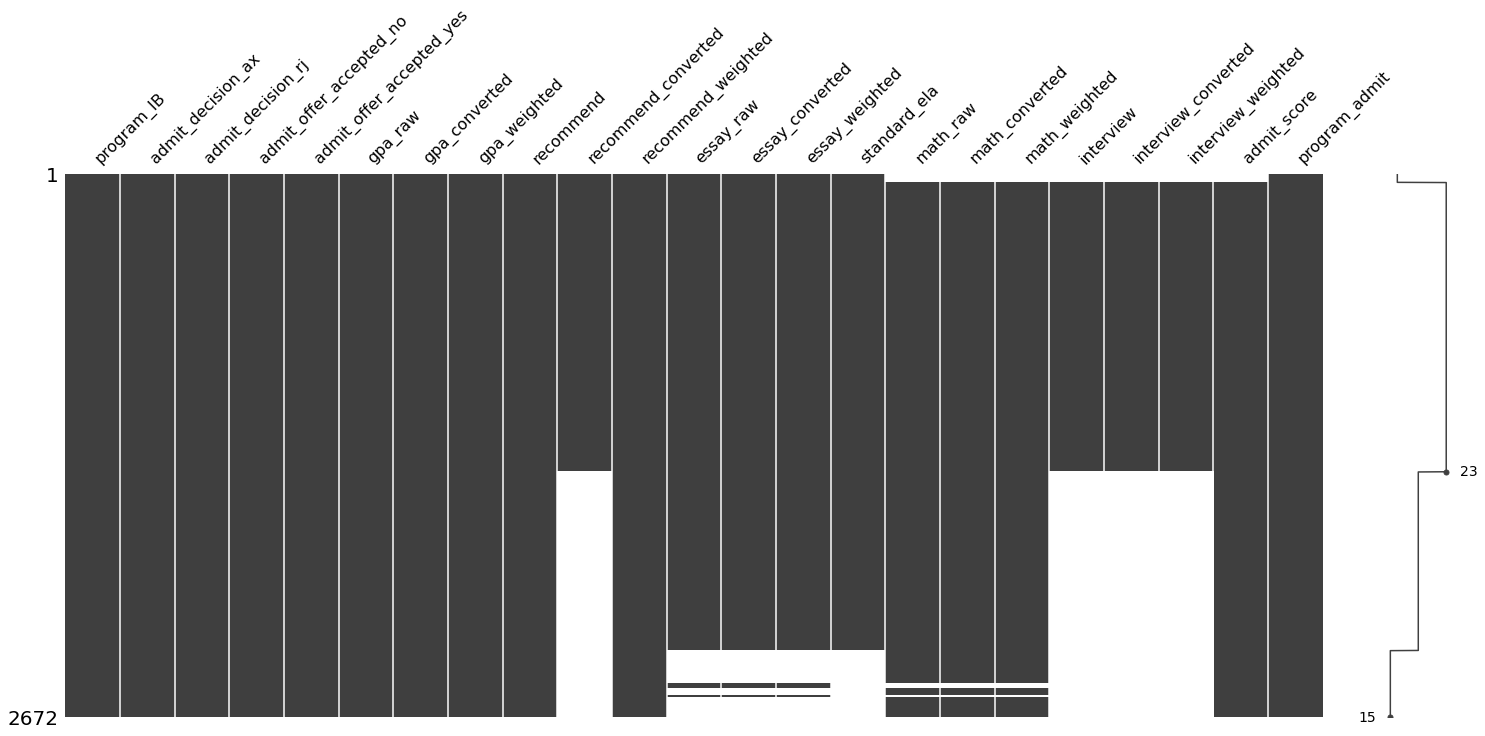

In [14]:
msno.matrix(df)

In [15]:
'''Pickle datafile'''
with open('mib_final_combine.pkl', 'wb') as f:
    pickle.dump(df, f)

In [17]:
'''Create separate dataframes for magnet and ib'''
ib_df = df.loc[df['program_IB'] == 1]
magnet_df = df.loc[df['program_IB'] == 0]

In [18]:
df.columns
plot_list = ['program_admit','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']

In [19]:
'''Create Silhouette and Centroid plots'''

def kmeans_evaluation(X, cluster_range):
    for n_cluster in cluster_range:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
        ax1.set_xlim([-.1, 1])
        ax1.set_ylim([0, len(X) + (n_cluster+1) * 10])

        clusterer = KMeans(n_clusters = n_cluster, init = 'k-means++', n_init = 300, max_iter = 500, random_state = 42)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print('For number of clusters = :', n_cluster, "The average silhouette score is ", silhouette_avg)

        sample_sil_values = silhouette_samples(X, cluster_labels)

        '''Sihouette Plots'''
        y_lower = 10
        for i in range(n_cluster):
            ith_sil_value = sample_sil_values[cluster_labels == i]
            ith_sil_value.sort()

            size_cluster_i = ith_sil_value.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i)/n_cluster)
            ax1.fill_betweenx(
            np.arange(y_lower, y_upper), 
                0,
                ith_sil_value,
                facecolor = color,
                edgecolor = color,
                alpha = .7
            )

            ax1.text(-.5, y_lower + .5 * size_cluster_i, str(i))
            y_lower = y_upper +10

            ax1.set_title('Silhouette plot for various clusters')
            ax1.set_xlabel('Silhouette coefficient values')
            ax1.set_ylabel('Cluster label')

            ax1.axvline(x=silhouette_avg, color = 'r', linestyle = '--')

            ax1.set_yticks([])
            ax1.set_xticks([-.1,0,.2,.4,.6,.8,1])

            '''Cluster plots'''
            color = cm.nipy_spectral(cluster_labels.astype(float)/n_cluster)
            ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker = '.', s=30, lw=0, alpha=.7, c=color, edgecolor = 'k')

            centers = clusterer.cluster_centers_
            ax2.scatter(
                centers[:, 0],
                centers[:, 1],
                marker = 'o',
                c='white',
                alpha = 1,
                s=200,
                edgecolor = 'k'
            )

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker = '$%d$' %i, alpha=1, s=50, edgecolor = 'k')

            ax2.set_title('Visualization of clustered data')
            ax2.set_xlabel('Feature space for 1st feature')
            ax2.set_ylabel('Feature space for 2nd feature')

            plt.suptitle(
                'Silhouette analysis for KMeans clustering on sample data with n_clusters = %d'
                % n_cluster,
                fontsize = 14,
                fontweight = 'bold'
            )

In [20]:
def qq_plot (df):
    for column in df.columns:
        print(column)
        sm.qqplot(df[column], line ='s', fit = True)

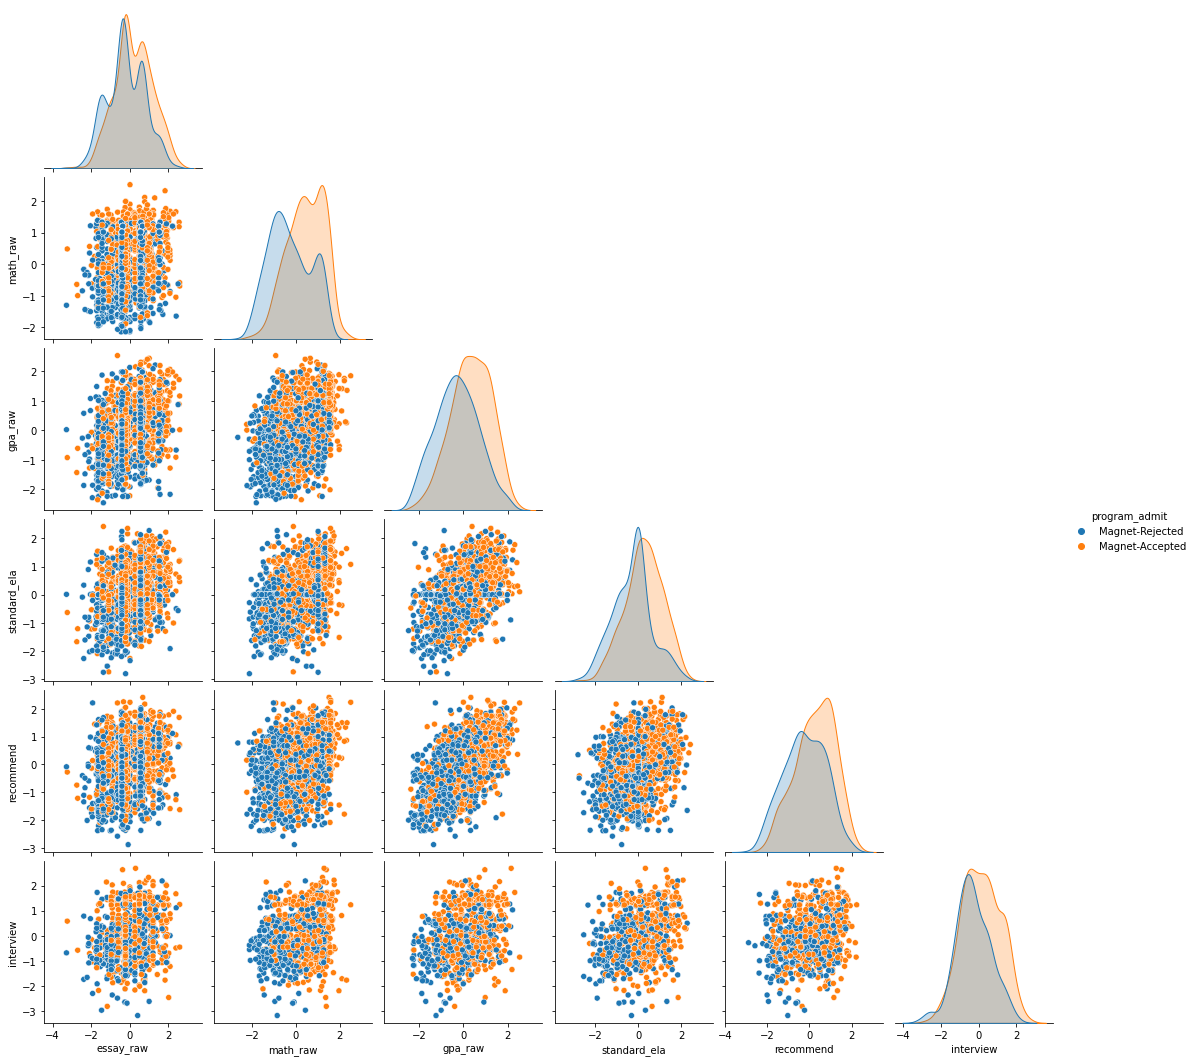

In [21]:
'''Create pariplots to show relationships between variables - Magnet'''
sns.pairplot(magnet_df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

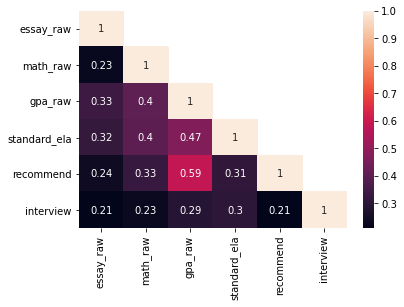

In [22]:
'''Correlation Heatmap - Magnet'''
df_corr_magnet = magnet_df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr_magnet), columns = df_corr_magnet.columns).replace(0, np.nan)
matrix.set_index(df_corr_magnet.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

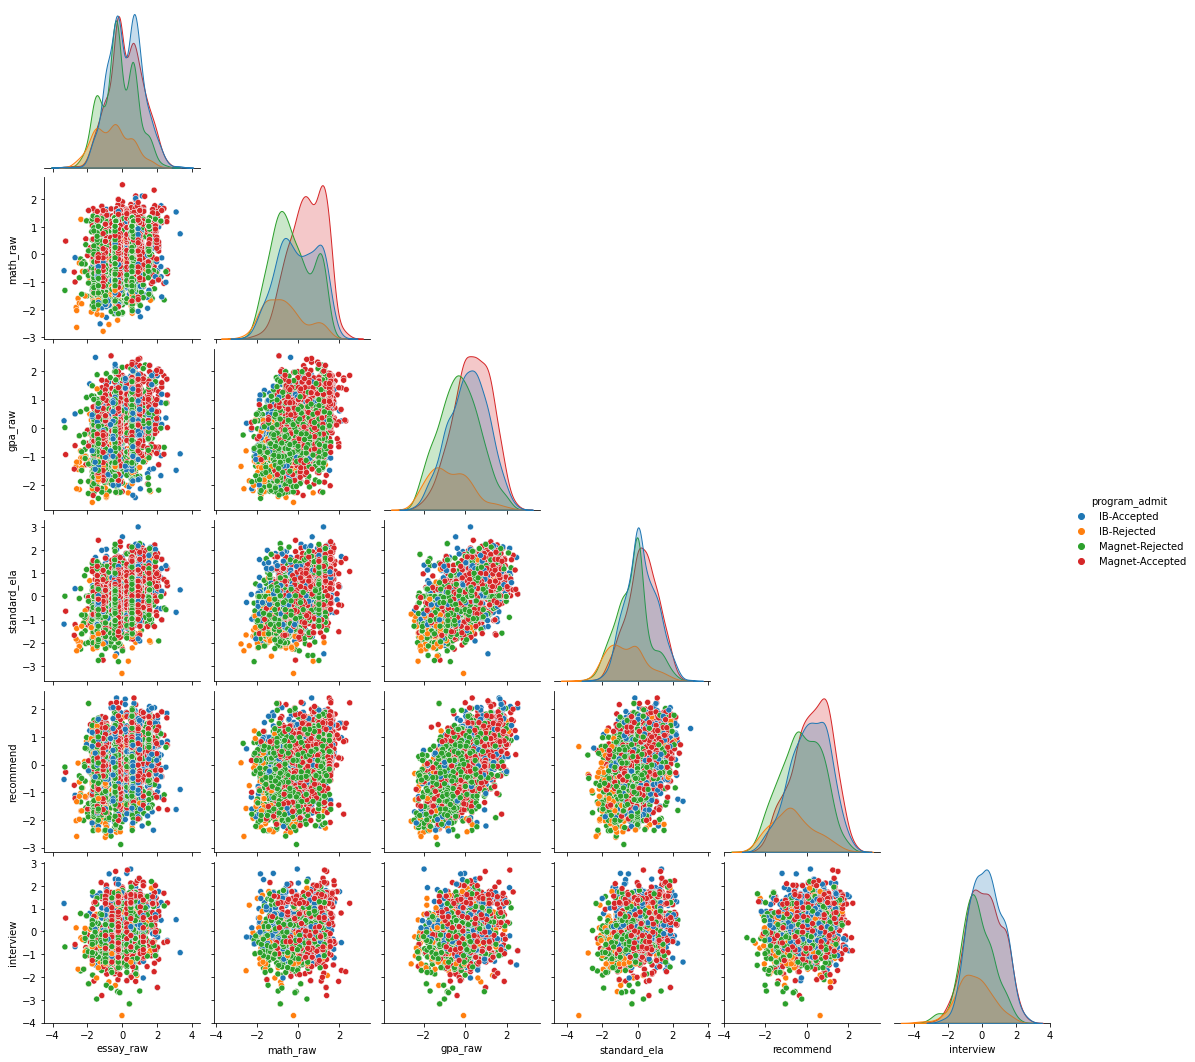

In [23]:
'''Create pariplots to show relationships between variables'''
sns.pairplot(df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

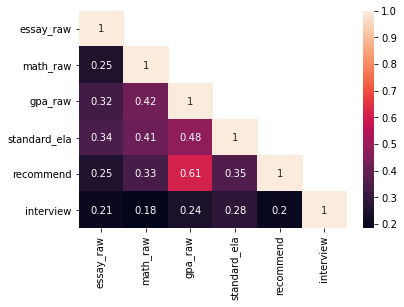

In [24]:
'''Correlation Heatmap for both programs'''
df_corr = df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr), columns = df_corr.columns).replace(0, np.nan)
matrix.set_index(df_corr.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

In [25]:
'''Function to perform PCA analysis'''

'''Split data into test and train IB'''
def conduct_pca(df, pca_list, n_components):
    X = df[pca_list].drop(pca_list[0], axis = 1)
    y = df[pca_list[0]].astype('int32')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state=42)
    
    '''Create PCA model'''
    pca = PCA(n_components = n_components)
    pca.fit(X_train, y_train)
    
    '''Find cumulative variance of components'''
    cum_variance = np.cumsum(pca.explained_variance_ratio_*100)
    variance = pca.explained_variance_ratio_*100

    '''Print explained variance with all factors'''
    print(f'Cumulative variance explained by model {cum_variance}')
    print(f'The explained variance for each factor is: {variance}')
    
    '''Create Scree Plot'''
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.xticks(np.arange(1,6,1));

    return pca, X, y, X_train, X_test, y_train, y_test

In [26]:
'''Function to draw PCA biplot retreived from: 
https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot'''

def myplot(score, coeff, y, labels = None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex, ys * scaley, c=y)

    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

### Magnet PCA Analysis - With Interview

In [27]:
magnet_df

,program_IB,admit_decision_ax,admit_decision_rj,admit_offer_accepted_no,admit_offer_accepted_yes,gpa_raw,gpa_converted,gpa_weighted,recommend,recommend_converted,...,essay_weighted,standard_ela,math_raw,math_converted,math_weighted,interview,interview_converted,interview_weighted,admit_score,program_admit
43,0.0,0.0,1.0,1.0,0.0,0.257922,-0.073822,0.953495,-1.074991,-0.866074,...,-1.261073,-0.475848,-0.587372,-1.303236,-1.177494,-0.780711,-2.065961,-1.576862,-1.592431,Magnet-Rejected
44,0.0,0.0,1.0,1.0,0.0,-1.716773,-1.415286,-0.409731,-0.869429,-0.677768,...,-1.114907,0.180987,-1.518667,-1.303236,-1.177494,-0.561539,-2.065961,-1.576862,-1.632763,Magnet-Rejected
45,0.0,1.0,0.0,1.0,0.0,1.411485,1.658246,2.512815,1.498323,1.367772,...,-1.114907,-0.381244,2.111854,1.053636,1.665207,-1.714638,-2.065961,-1.576862,1.307310,Magnet-Accepted
46,0.0,1.0,0.0,0.0,1.0,1.883783,1.658246,2.512815,1.324729,1.223645,...,-1.114907,0.504843,1.973812,1.053636,1.665207,-2.194314,-0.658551,-1.282089,1.849077,Magnet-Accepted
47,0.0,1.0,0.0,0.0,1.0,0.602581,0.743211,1.709849,0.525293,0.549662,...,-1.400571,0.504843,1.138698,0.833934,1.543294,-0.605345,0.281382,-1.126989,0.498953,Magnet-Accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,0.0,0.0,1.0,1.0,0.0,0.843671,1.385999,1.446477,0.479422,NaN,...,NaN,NaN,0.636189,0.526179,0.526215,NaN,NaN,NaN,1.475134,Magnet-Rejected
2668,0.0,0.0,1.0,1.0,0.0,-0.061494,-0.587112,-0.498627,0.018888,NaN,...,NaN,NaN,-0.633526,0.526179,0.526215,NaN,NaN,NaN,-0.214459,Magnet-Rejected
2669,0.0,0.0,1.0,1.0,0.0,-0.633688,-0.587112,-0.498627,-0.590497,NaN,...,NaN,NaN,-1.102266,-1.664798,-1.666187,NaN,NaN,NaN,-0.739985,Magnet-Rejected
2670,0.0,0.0,1.0,1.0,0.0,-1.809772,-1.965690,-1.860470,-0.944956,NaN,...,NaN,NaN,-1.874311,-2.151008,-2.149454,NaN,NaN,NaN,-2.172079,Magnet-Rejected


In [28]:
magnet_df_interview = magnet_df.dropna(how = 'any')

In [29]:
magnet_df_interview

,program_IB,admit_decision_ax,admit_decision_rj,admit_offer_accepted_no,admit_offer_accepted_yes,gpa_raw,gpa_converted,gpa_weighted,recommend,recommend_converted,...,essay_weighted,standard_ela,math_raw,math_converted,math_weighted,interview,interview_converted,interview_weighted,admit_score,program_admit
43,0.0,0.0,1.0,1.0,0.0,0.257922,-0.073822,0.953495,-1.074991,-0.866074,...,-1.261073,-0.475848,-0.587372,-1.303236,-1.177494,-0.780711,-2.065961,-1.576862,-1.592431,Magnet-Rejected
44,0.0,0.0,1.0,1.0,0.0,-1.716773,-1.415286,-0.409731,-0.869429,-0.677768,...,-1.114907,0.180987,-1.518667,-1.303236,-1.177494,-0.561539,-2.065961,-1.576862,-1.632763,Magnet-Rejected
45,0.0,1.0,0.0,1.0,0.0,1.411485,1.658246,2.512815,1.498323,1.367772,...,-1.114907,-0.381244,2.111854,1.053636,1.665207,-1.714638,-2.065961,-1.576862,1.307310,Magnet-Accepted
46,0.0,1.0,0.0,0.0,1.0,1.883783,1.658246,2.512815,1.324729,1.223645,...,-1.114907,0.504843,1.973812,1.053636,1.665207,-2.194314,-0.658551,-1.282089,1.849077,Magnet-Accepted
47,0.0,1.0,0.0,0.0,1.0,0.602581,0.743211,1.709849,0.525293,0.549662,...,-1.400571,0.504843,1.138698,0.833934,1.543294,-0.605345,0.281382,-1.126989,0.498953,Magnet-Accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,0.0,1.0,0.0,0.0,1.0,-1.103042,-0.903344,-1.004848,-1.356025,-1.356025,...,-0.246733,0.139196,-0.503308,-0.598780,0.599001,0.849468,0.939978,0.057821,-0.116312,Magnet-Accepted
1461,0.0,1.0,0.0,0.0,1.0,-0.459086,-0.098901,-0.623163,-0.905660,-0.905660,...,-0.246733,-1.035485,0.578878,0.382415,0.985270,-0.803857,-0.862372,-0.915672,-0.161451,Magnet-Accepted
1462,0.0,1.0,0.0,0.0,1.0,1.162900,0.826505,-0.235047,1.337066,1.337066,...,-1.002500,1.656352,0.068527,-0.131050,0.798654,1.229969,1.318591,0.237976,0.624853,Magnet-Accepted
1463,0.0,1.0,0.0,0.0,1.0,-0.288928,-0.098901,-0.623163,-1.172320,-1.172320,...,-0.246733,-0.173258,0.525031,0.382415,0.985270,-0.507244,-0.162238,-0.508917,0.153178,Magnet-Accepted


<AxesSubplot:>

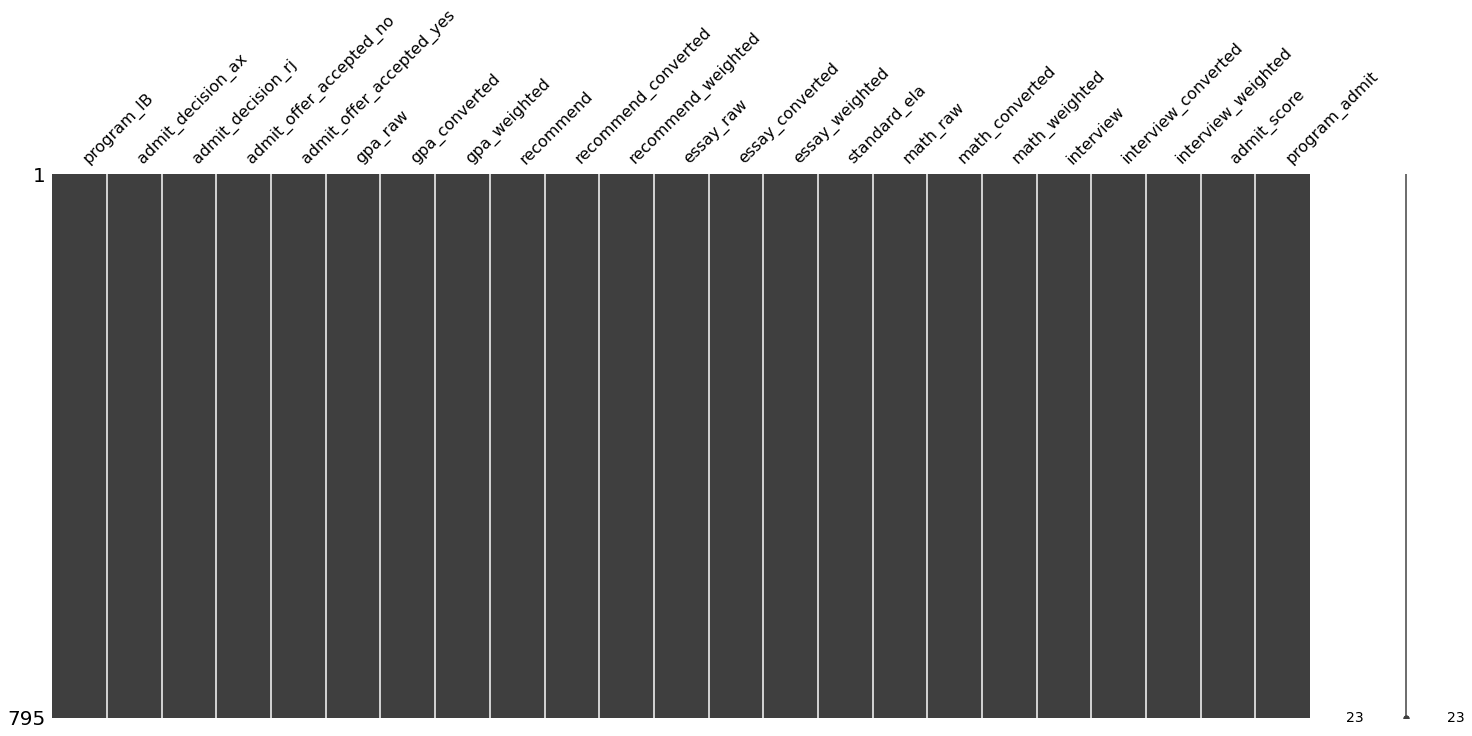

In [30]:
msno.matrix(magnet_df_interview)

<AxesSubplot:>

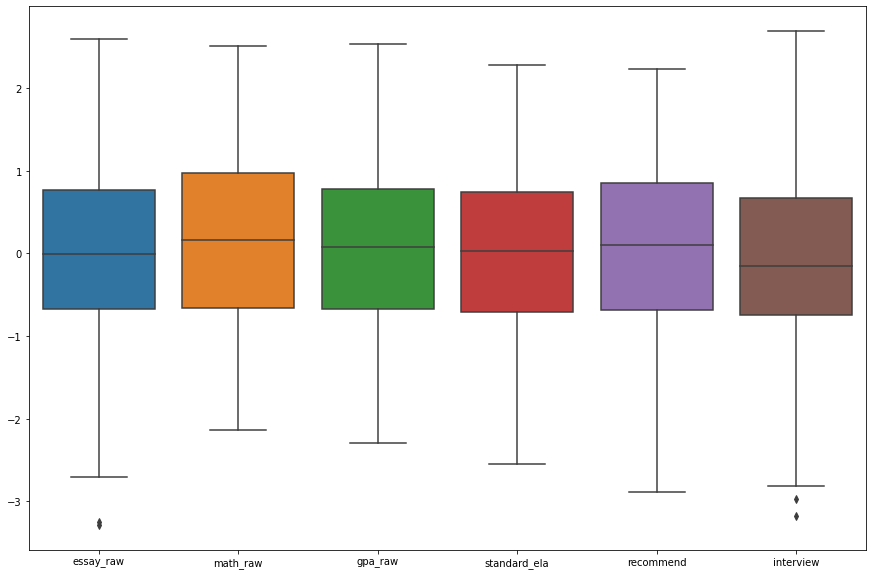

In [31]:
plot_list = ['essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']

fig, ax = plt.subplots(figsize= (15, 10))
sns.boxplot(data = magnet_df_interview[plot_list])

In [32]:
for column in magnet_df_interview[plot_list]:
    print(column, skewtest(magnet_df_interview[column], nan_policy = 'propagate'))

essay_raw SkewtestResult(statistic=-0.36338529460420077, pvalue=0.7163170852940504)
math_raw SkewtestResult(statistic=-2.0411254351406063, pvalue=0.041238360796944463)
gpa_raw SkewtestResult(statistic=-1.2883815374466663, pvalue=0.19761318234539915)
standard_ela SkewtestResult(statistic=-1.0374772556328915, pvalue=0.2995134902117057)
recommend SkewtestResult(statistic=-3.0345413544568234, pvalue=0.0024090172597811686)
interview SkewtestResult(statistic=0.29121953850160837, pvalue=0.770883420303474)


Cumulative variance explained by model [ 44.87434804  60.38236282  74.0173457   85.42080905  94.72657366
 100.        ]
The explained variance for each factor is: [44.87434804 15.50801478 13.63498289 11.40346334  9.30576461  5.27342634]


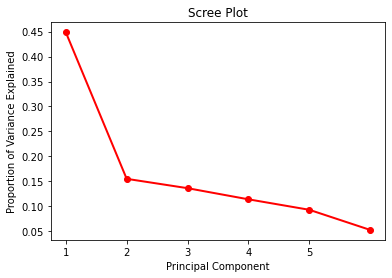

In [34]:
'''Conduct PCA on Magnet data with 6 components'''
pca_list = ['program_IB','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_df_interview, pca_list, 6)

Cumulative variance explained by model [44.87434804 60.38236282]
The explained variance for each factor is: [44.87434804 15.50801478]


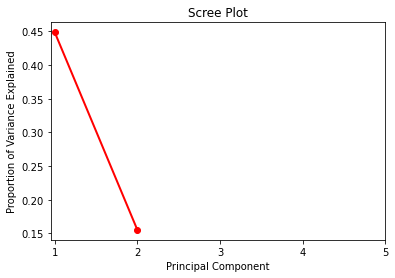

In [35]:
'''Conduct PCA on Magnet data with 2 components'''
pca_list = ['program_IB','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_df_interview, pca_list, 2)

In [36]:
'''Calculate pc loadings - Magnet'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_train.columns)
loadings

,PC1,PC2
essay_raw,-0.3324,0.6382
math_raw,-0.3894,-0.2014
gpa_raw,-0.4957,-0.2586
standard_ela,-0.4343,0.2432
recommend,-0.4647,-0.5037
interview,-0.2960,0.4151


In [37]:
'''Transform Magnet Data'''
pca_trans = pca.transform(X_test)
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

magnet_interview_pca_df = pd.DataFrame(pca.transform(X), columns = ['PC1', 'PC2'])
magnet_interview_pca_df['program_admit'] = magnet_df_interview['program_admit'].values

In [38]:
'''Pickle datafile'''
with open('magnet_interview_pca.pkl', 'wb') as f:
    pickle.dump(magnet_interview_pca_df, f)

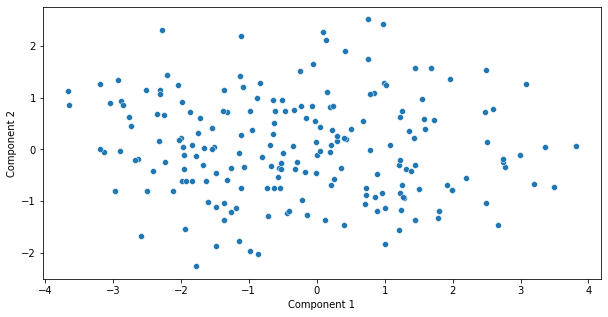

In [39]:
'''Plot Primary Components'''
plt.figure(figsize=(10,5))
sns.scatterplot(x = pca_trans[:,0], y = pca_trans[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2');

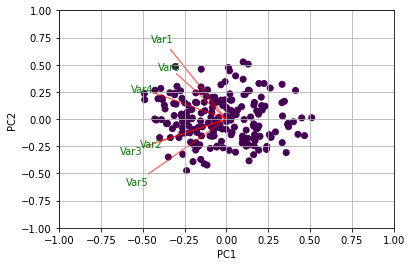

In [40]:
'''Create biplot for Magnet PCA'''
myplot(pca_trans[:,0:2],np.transpose(pca.components_[0:2, :]), y_test)

For number of clusters = : 2 The average silhouette score is  0.4267110096337489
For number of clusters = : 3 The average silhouette score is  0.33172365413673494
For number of clusters = : 4 The average silhouette score is  0.36083828526715167
For number of clusters = : 5 The average silhouette score is  0.3538354402954862
For number of clusters = : 6 The average silhouette score is  0.3612421648298635
For number of clusters = : 7 The average silhouette score is  0.348205919831278


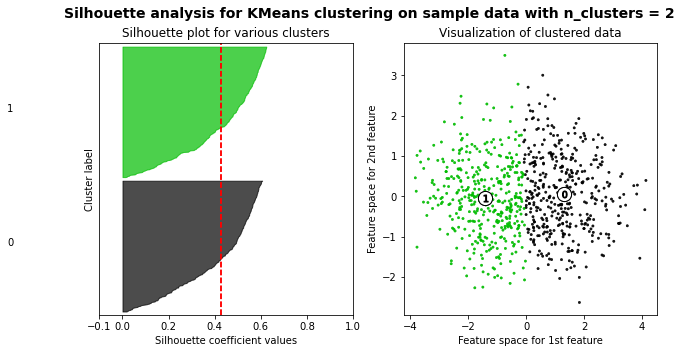

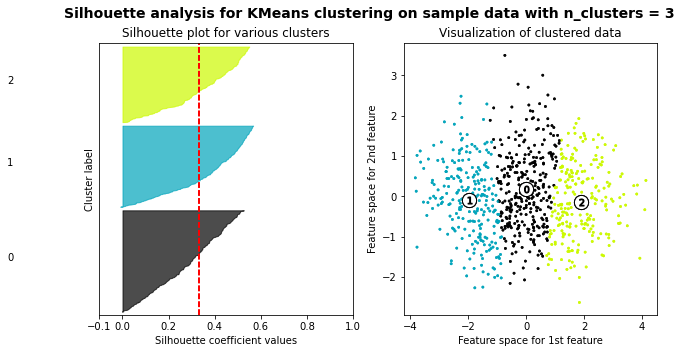

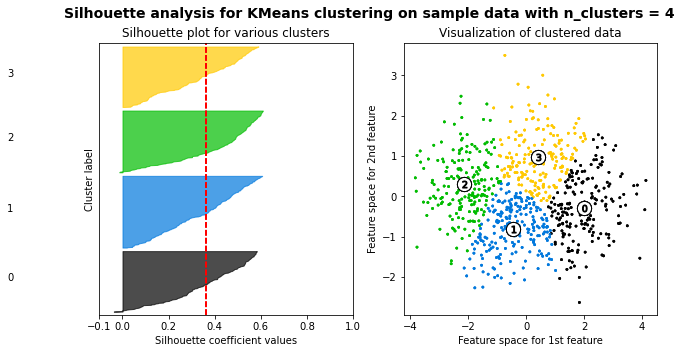

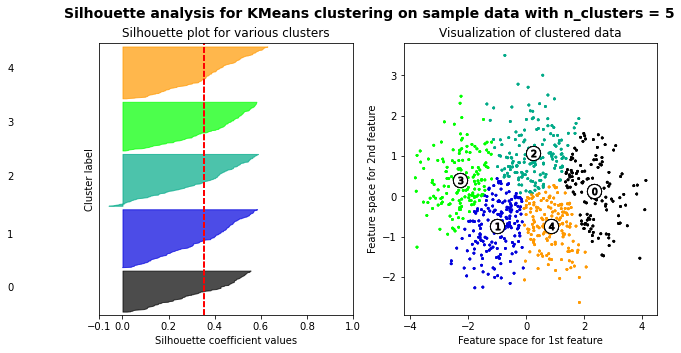

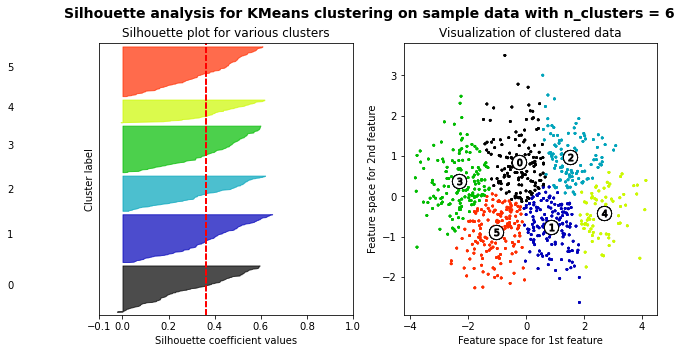

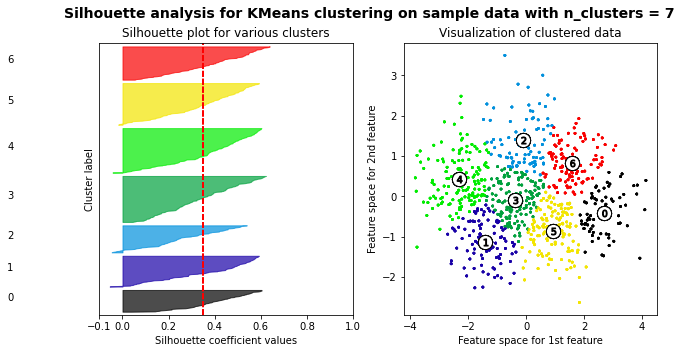

In [41]:
'''Create KMeans model'''
X = magnet_interview_pca_df.drop('program_admit', axis = 1)
y = magnet_interview_pca_df['program_admit']

cluster_range = np.arange(2,8)
kmeans_evaluation(X, cluster_range)

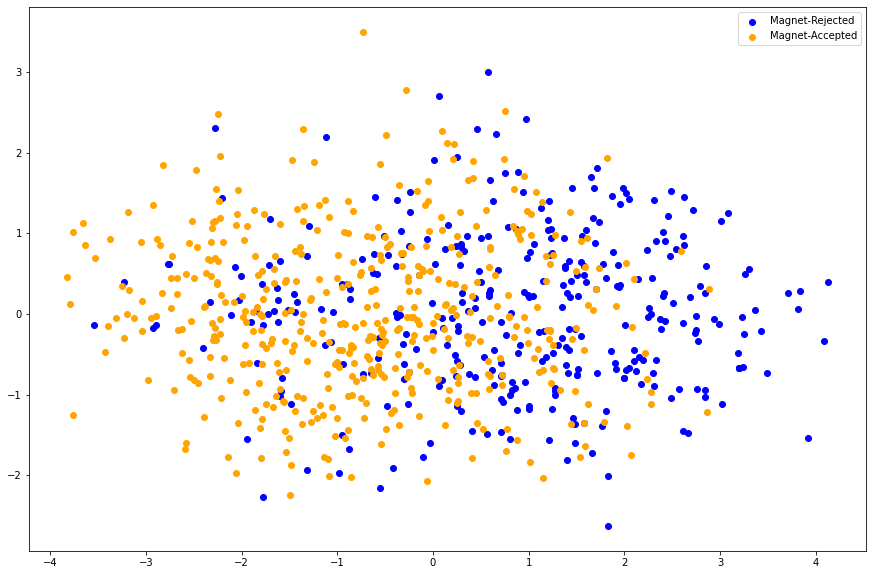

In [42]:
'''Plot data against acceptance status'''
fig, ax = plt.subplots(figsize = (15, 10))

color_dict = {}
color_list = ['b', 'orange']
admit_status = pd.Series(list(magnet_interview_pca_df['program_admit']))
for index, status in enumerate(magnet_interview_pca_df['program_admit'].unique()):
    color_dict[status] = color_list[index]

for index, status in enumerate(magnet_interview_pca_df['program_admit'].unique()):
    ix = np.where(magnet_interview_pca_df['program_admit'] == status)
    ax.scatter(x = X['PC1'].to_numpy()[ix], y = X['PC2'].to_numpy()[ix], c = color_dict[status], label = status)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend()

### Magnet Analysis - without interview

In [43]:
magnet_df

,program_IB,admit_decision_ax,admit_decision_rj,admit_offer_accepted_no,admit_offer_accepted_yes,gpa_raw,gpa_converted,gpa_weighted,recommend,recommend_converted,...,essay_weighted,standard_ela,math_raw,math_converted,math_weighted,interview,interview_converted,interview_weighted,admit_score,program_admit
43,0.0000,0.0000,1.0000,1.0000,0.0000,0.2579,-0.0738,0.9535,-1.0750,-0.8661,...,-1.2611,-0.4758,-0.5874,-1.3032,-1.1775,-0.7807,-2.0660,-1.5769,-1.5924,Magnet-Rejected
44,0.0000,0.0000,1.0000,1.0000,0.0000,-1.7168,-1.4153,-0.4097,-0.8694,-0.6778,...,-1.1149,0.1810,-1.5187,-1.3032,-1.1775,-0.5615,-2.0660,-1.5769,-1.6328,Magnet-Rejected
45,0.0000,1.0000,0.0000,1.0000,0.0000,1.4115,1.6582,2.5128,1.4983,1.3678,...,-1.1149,-0.3812,2.1119,1.0536,1.6652,-1.7146,-2.0660,-1.5769,1.3073,Magnet-Accepted
46,0.0000,1.0000,0.0000,0.0000,1.0000,1.8838,1.6582,2.5128,1.3247,1.2236,...,-1.1149,0.5048,1.9738,1.0536,1.6652,-2.1943,-0.6586,-1.2821,1.8491,Magnet-Accepted
47,0.0000,1.0000,0.0000,0.0000,1.0000,0.6026,0.7432,1.7098,0.5253,0.5497,...,-1.4006,0.5048,1.1387,0.8339,1.5433,-0.6053,0.2814,-1.1270,0.4990,Magnet-Accepted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,0.0000,0.0000,1.0000,1.0000,0.0000,0.8437,1.3860,1.4465,0.4794,nan,...,nan,nan,0.6362,0.5262,0.5262,nan,nan,nan,1.4751,Magnet-Rejected
2668,0.0000,0.0000,1.0000,1.0000,0.0000,-0.0615,-0.5871,-0.4986,0.0189,nan,...,nan,nan,-0.6335,0.5262,0.5262,nan,nan,nan,-0.2145,Magnet-Rejected
2669,0.0000,0.0000,1.0000,1.0000,0.0000,-0.6337,-0.5871,-0.4986,-0.5905,nan,...,nan,nan,-1.1023,-1.6648,-1.6662,nan,nan,nan,-0.7400,Magnet-Rejected
2670,0.0000,0.0000,1.0000,1.0000,0.0000,-1.8098,-1.9657,-1.8605,-0.9450,nan,...,nan,nan,-1.8743,-2.1510,-2.1495,nan,nan,nan,-2.1721,Magnet-Rejected


<AxesSubplot:>

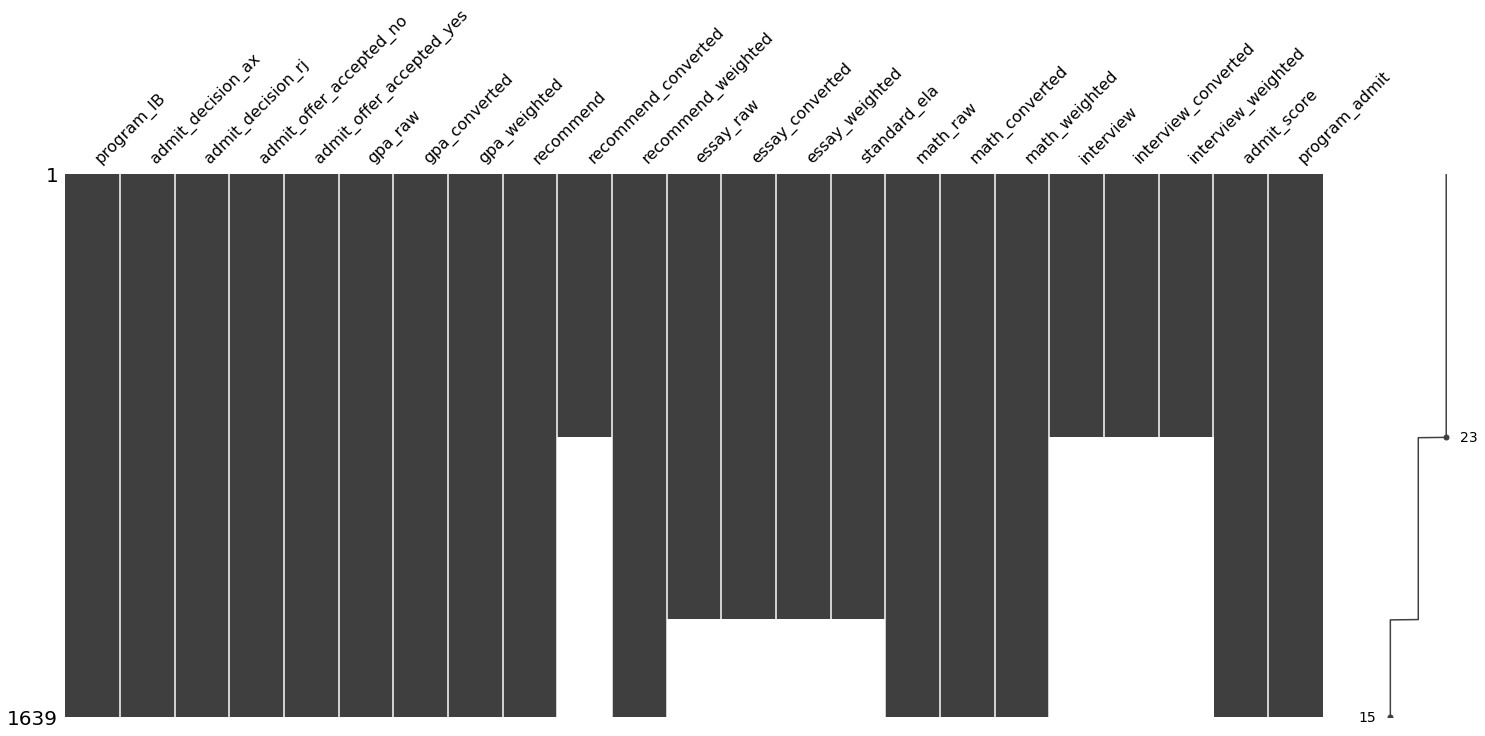

In [44]:
msno.matrix(magnet_df)

In [45]:
magnet_df['essay_raw'].fillna(magnet_df['essay_raw'].mean(), inplace = True)
magnet_df['standard_ela'].fillna(magnet_df['standard_ela'].mean(), inplace = True)
drop_list = ['recommend_converted', 'interview', 'interview_converted', 'interview_weighted',\
            'essay_converted', 'essay_weighted']
magnet_no_interview = magnet_df.drop(drop_list, axis = 1)

C:\Users\scott\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<AxesSubplot:>

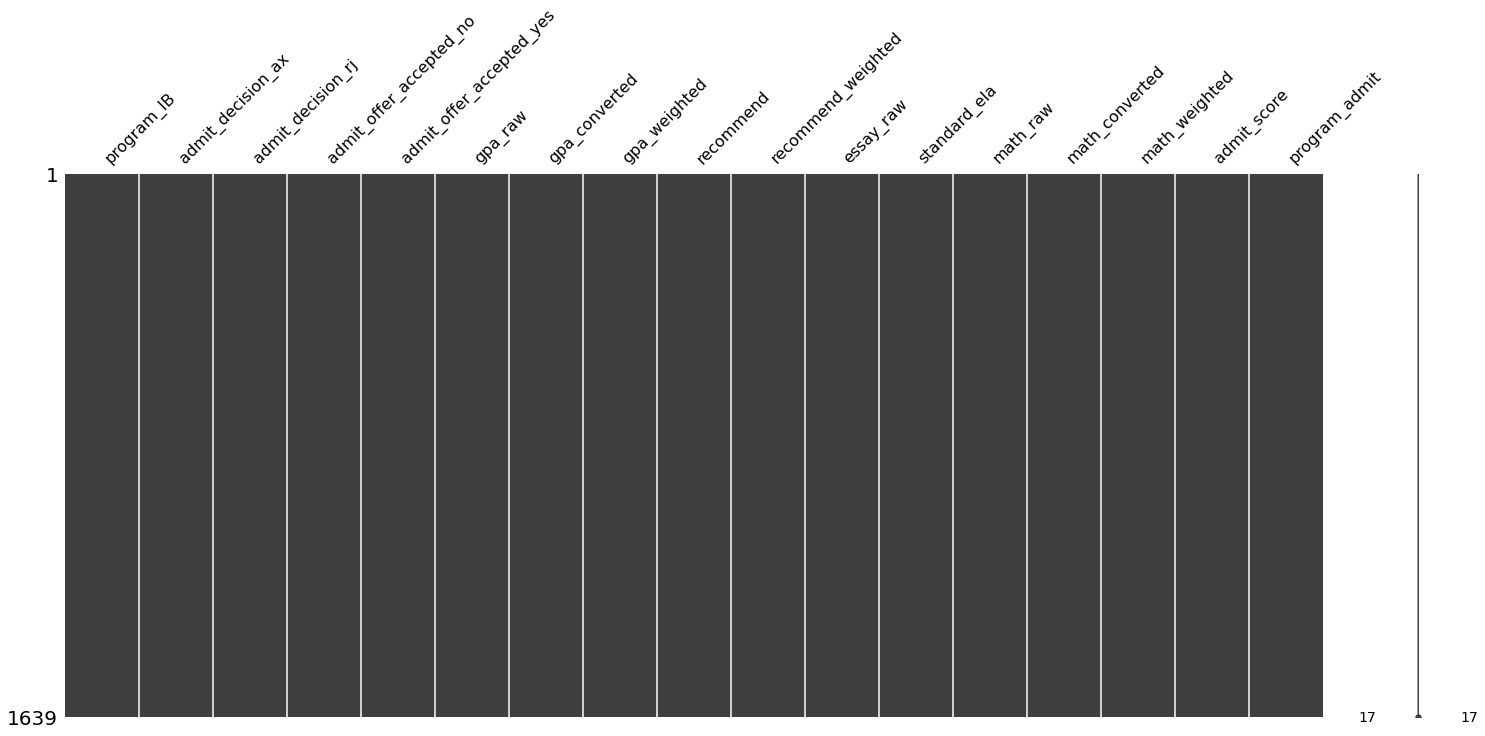

In [46]:
msno.matrix(magnet_no_interview)

Cumulative variance explained by model [ 49.07296795  65.73773498  80.92084293  91.55537075 100.        ]
The explained variance for each factor is: [49.07296795 16.66476703 15.18310795 10.63452782  8.44462925]


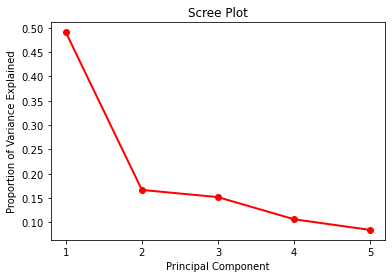

In [48]:
'''Conduct PCA on Magnet data with 5 components'''
pca_list = ['program_IB', 'math_raw', 'gpa_raw', 'recommend', 'essay_raw', 'standard_ela']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_no_interview, pca_list, 5)

Cumulative variance explained by model [49.07296795 65.73773498]
The explained variance for each factor is: [49.07296795 16.66476703]


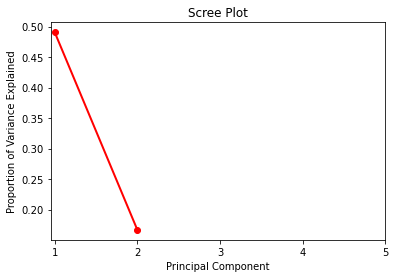

In [49]:
'''Conduct PCA on Magnet data with 2 components'''
pca_list = ['program_IB', 'math_raw', 'gpa_raw', 'recommend', 'essay_raw', 'standard_ela']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_no_interview, pca_list, 2)

In [50]:
'''Calculate pc loadings - Magnet'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_train.columns)
loadings

,PC1,PC2
math_raw,-0.4436,0.1833
gpa_raw,-0.5600,-0.2426
recommend,-0.5182,-0.5468
essay_raw,-0.3165,0.7082
standard_ela,-0.3478,0.3271


In [51]:
'''Transform Magnet Data'''
pca_trans = pca.transform(X_test)
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

magnet_no_interview_pca_df = pd.DataFrame(pca.transform(X), columns = ['PC1', 'PC2'])
magnet_no_interview_pca_df['program_admit'] = magnet_no_interview['program_admit'].values

In [52]:
'''Pickle datafile'''
with open('magnet_no_interview_pca.pkl', 'wb') as f:
    pickle.dump(magnet_no_interview_pca_df, f)

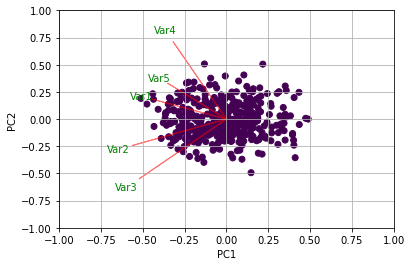

In [53]:
'''Create biplot for Magnet PCA'''
myplot(pca_trans[:,0:2],np.transpose(pca.components_[0:2, :]), y_test)

For number of clusters = : 2 The average silhouette score is  0.41808035639271524
For number of clusters = : 3 The average silhouette score is  0.3345845955160774
For number of clusters = : 4 The average silhouette score is  0.3321141720740615
For number of clusters = : 5 The average silhouette score is  0.3284291962385559
For number of clusters = : 6 The average silhouette score is  0.33748082045440475
For number of clusters = : 7 The average silhouette score is  0.34334305281266586


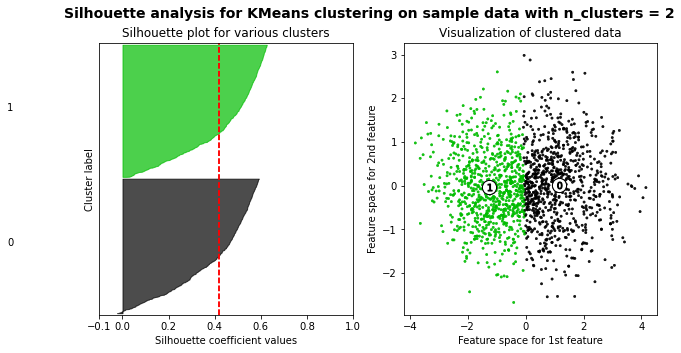

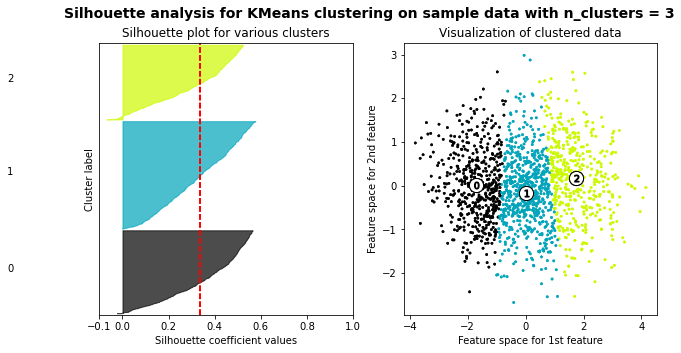

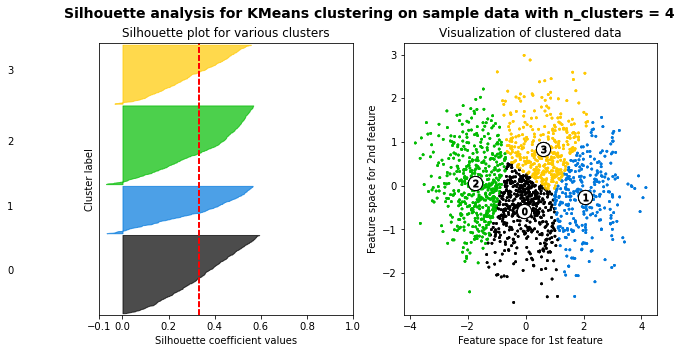

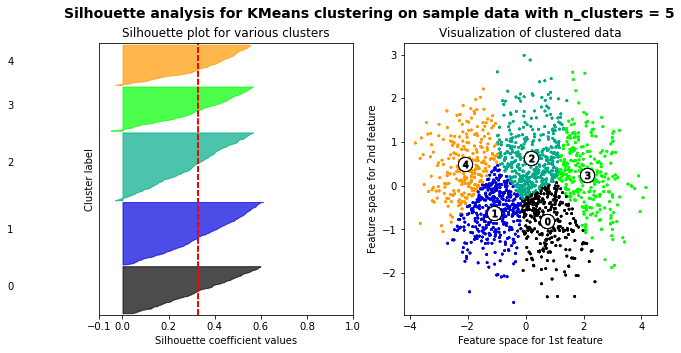

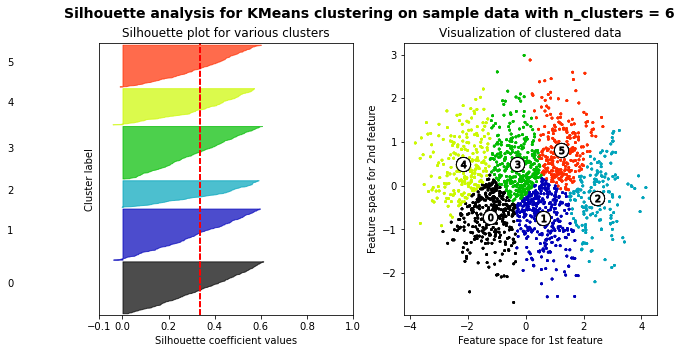

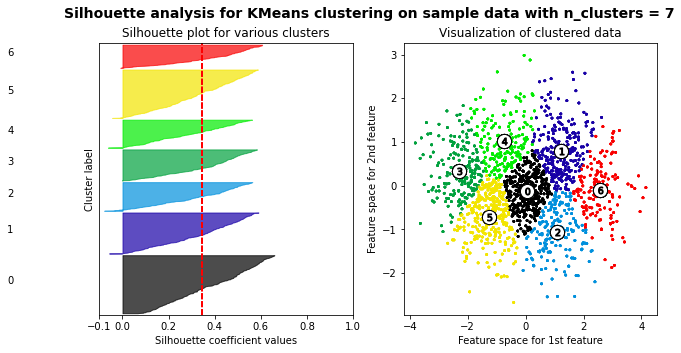

In [54]:
'''Create KMeans model'''
X = magnet_no_interview_pca_df.drop('program_admit', axis = 1)
y = magnet_no_interview_pca_df['program_admit']

cluster_range = np.arange(2,8)
kmeans_evaluation(X, cluster_range)

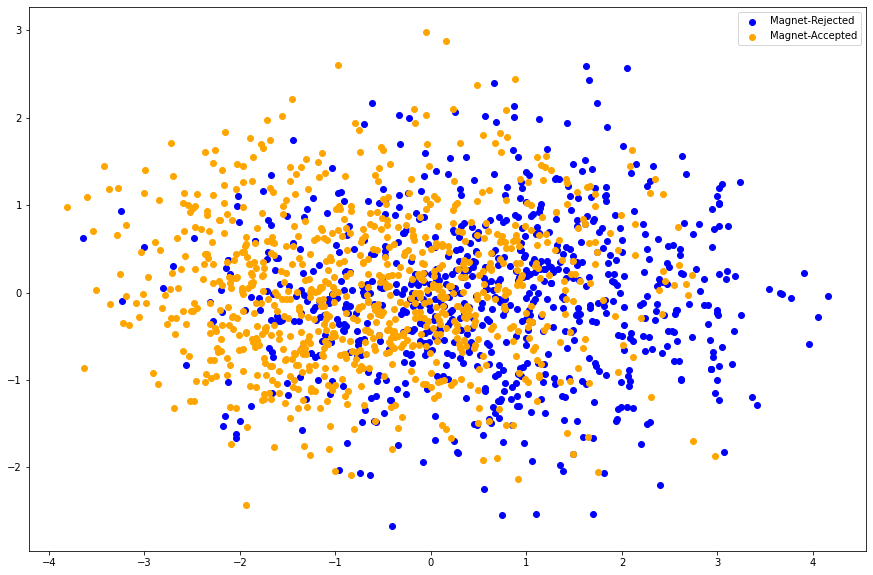

In [55]:
'''Plot data against acceptance status'''
fig, ax = plt.subplots(figsize = (15, 10))

color_dict = {}
color_list = ['b', 'orange']
admit_status = pd.Series(list(magnet_no_interview_pca_df['program_admit']))
for index, status in enumerate(magnet_no_interview_pca_df['program_admit'].unique()):
    color_dict[status] = color_list[index]

for index, status in enumerate(magnet_no_interview_pca_df['program_admit'].unique()):
    ix = np.where(magnet_no_interview_pca_df['program_admit'] == status)
    ax.scatter(x = X['PC1'].to_numpy()[ix], y = X['PC2'].to_numpy()[ix], c = color_dict[status], label = status)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend()